! pip install anchor-exp graphviz

In [4]:
import pathlib
pathlib.Path().resolve()

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("notebooks/knack/knac")

import math

import pandas as pd
import xgboost as xgb
import numpy as np
from pylab import rcParams
from anchor import anchor_tabular
from knac_scikit import KnacSplits, KnacMerges

from matplotlib import pyplot as plt

from typing import List, Optional

rcParams['figure.figsize'] = 50, 10

def plot_roc(model, dataset, features, target, saveas=None):
    from itertools import cycle

    from sklearn.metrics import roc_curve,auc
    from sklearn.preprocessing import label_binarize
    from scipy import interp
    
    n_classes = len(np.unique(dataset[target]))
    
    if hasattr(model ,'decision_function'):
        y_score = model.decision_function(dataset[features])
    else:
        if n_classes < 3:
            y_score = model.predict_proba(dataset[features])[::,1]
        else:
            y_score = model.predict_proba(dataset[features])
    y = label_binarize(dataset[target], classes=np.unique(dataset[target]))


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        if n_classes > 2:
            fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        else:
            fpr[i], tpr[i], _ = roc_curve(dataset[target], y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    if n_classes > 2:
        fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
    else:
        fpr["micro"], tpr["micro"], _ = roc_curve(dataset[target], y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2

    fig=plt.figure(figsize=(12,9))
    plt.plot(fpr["micro"], tpr["micro"],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]),
           color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'gold', 'khaki', 'red', 'violet','purple'])
    for i, color in zip(range(n_classes), colors):
          plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC analysis')
    plt.legend(loc="lower right")
    plt.show()
    if saveas is not None:
        fig.savefig(saveas)


def get_rules(tree, feature_names, class_names):
    from sklearn.tree import _tree
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]

    return rules


def justify_splits_anchor(expert_to_split, split_recoms, data, features, target_automatic='C'):
    model = xgb.XGBClassifier(use_label_encoder=False,eval_metric='mlogloss')
    model.fit(data[features].values,data[target_automatic])
    ds = data[data[target_automatic].isin(split_recoms)]
    centers_anchor = ds.groupby(target_automatic).mean()

    explainerx = anchor_tabular.AnchorTabularExplainer(
        ds.C.to_list(),
        feature_names = centers_anchor[features].columns,

        train_data = ds[features].values)


    for idx in split_recoms:
        exp = explainerx.explain_instance(centers_anchor[features].loc[idx].values, model.predict, threshold=0.85)
        print(f'The rule for automatic cluster {idx}: %s' % (' AND '.join(exp.names())))
        print('Precision: %.2f' % exp.precision())
        print('Coverage: %.2f' % exp.coverage())


def justify_splits_tree(expert_to_split, split_recoms, data, features, target_automatic='C'):
    from sklearn import tree
    from graphviz import Source

    ds_local = data.copy()
    ds_local = ds_local[ds_local[target_automatic].isin(split_recoms)]
    # centers_anchor_local = ds_local.groupby(target_automatic).mean()

    estimator_local_simple = tree.DecisionTreeClassifier(max_depth=1)
    estimator_local_simple.fit(ds_local[features], ds_local[target_automatic])


    Source(tree.export_graphviz(estimator_local_simple, out_file=None
                                        , feature_names=features, class_names=[str(f) for f in estimator_local_simple.classes_]
                                        , filled = True))

    return get_rules(estimator_local_simple, feature_names=features, class_names=[str(cn) for cn in estimator_local_simple.classes_])


def justify_merges_anchor(merge_recoms, data, features, target_expert='E'):
    from sklearn.preprocessing import LabelEncoder
    model_exp = xgb.XGBClassifier(use_label_encoder=True,eval_metric='mlogloss') # TODO
    le_exp = LabelEncoder()
    le_exp.fit(data[target_expert])
    model_exp.fit(data[features].values,data[target_expert])
    ds_exp = data[data[target_expert].isin(merge_recoms)]
    centers_exp = ds_exp.groupby(target_expert).mean()

    explainer_exp = anchor_tabular.AnchorTabularExplainer(
        le_exp.classes_,
        feature_names = centers_exp[features].columns,
        train_data = data[features].values,
        categorical_names={})


    for idx in merge_recoms:
        exp = explainer_exp.explain_instance(centers_exp[features].loc[idx].values, model_exp.predict, threshold=0.85)
        print(f'The rule for automatic cluster {idx}: %s' % (' AND '.join(exp.names())))
        print('Precision: %.2f' % exp.precision())
        print('Coverage: %.2f' % exp.coverage())


def justify_merges_tree(merge_recoms, data, features, target_expert='E'):
    from sklearn import tree
    from graphviz import Source
    from sklearn.preprocessing import LabelEncoder

    le_exp = LabelEncoder()
    le_exp.fit(data[target_expert])
    ds_exp = data[data[target_expert].isin(merge_recoms)]
    # centers_anchor_local = ds_exp.groupby(target_expert).mean()

    estimator_local_simple_exp = tree.DecisionTreeClassifier(max_depth=1)
    estimator_local_simple_exp.fit(ds_exp[features], le_exp.transform(ds_exp[target_expert]))


    Source(tree.export_graphviz(estimator_local_simple_exp, out_file=None
                                        , feature_names=features, class_names=[str(f) for f in estimator_local_simple_exp.classes_]
                                        , filled = True))

    return get_rules(estimator_local_simple_exp, feature_names=features, class_names=[str(cn) for cn in estimator_local_simple_exp.classes_])


# Agg on cluster level:
def clusters_to_observations(df_clusters, df_observations, cluster_col):
    result_df = []
    df_observations[cluster_col] = -1

    for _, row in df_clusters.iterrows():
        obs_start = row['obs_start']
        obs_end = row['obs_end']
        df_slice = df_observations.loc[obs_start:obs_end, :].copy()
        df_slice[cluster_col] = row[cluster_col]
        df_slice['window_idx'] = row['window_idx']
        result_df.append(df_slice)

    return pd.concat(result_df)


def get_agg_stats_by_clusters(df:pd.DataFrame, by:str, values_col:str, clustering_columns:Optional[List[str]]=None) -> pd.DataFrame:
    df.sort_values(by=[by], inplace=True)

    data_agg = df.groupby(by).apply(lambda grp: grp.mean())[values_col].reset_index()
    data_agg.rename(columns={values_col: f"{values_col}_mean"}, inplace=True)
    data_agg[f"{values_col}_std"] =\
        df.groupby(by).apply(lambda grp: grp.std())[values_col].reset_index()[values_col]
    data_agg[f"{values_col}_min"] =\
        df.groupby(by).apply(lambda grp: grp.min())[values_col].reset_index()[values_col]
    data_agg[f"{values_col}_max"] =\
        df.groupby(by).apply(lambda grp: grp.max())[values_col].reset_index()[values_col]

    if clustering_columns:
        for c_col in clustering_columns:
            data_agg[c_col] =\
                df.groupby(by)[c_col].agg(pd.Series.mode)
            if pd.isnull(data_agg.loc[data_agg[by]==data_agg[by][0]][c_col]).any():
                print(f"for '{by}'={data_agg[by][0]} got '{c_col}'={df.loc[df[by]==data_agg[by][0]][c_col].unique()}")
                data_agg.loc[data_agg[by] == data_agg[by][0], c_col] = df.loc[df[by]==data_agg[by][0]][c_col].unique()[0]

    df.sort_values(by=['time'], inplace=True)
    return data_agg#.reset_index()


# Remove beginning of a series:
def remove_obs_based_on_windows(df_clusters_windows_from_dvats, df_clusters_observations_from_dvats, df_data, cluster_col, windows_size, stride):
    number_of_cluster = len(df_clusters_windows_from_dvats[cluster_col].unique())
    print(f"got {number_of_cluster} clusters from DeepVATS")

    clusters_vote_min_count = math.ceil((windows_size / stride) / number_of_cluster)
    df_clusters_observations_from_dvats['cluster_count'] = df_clusters_observations_from_dvats['clusters'].apply(lambda x: len(x.split(', ')))
    return df_data.loc[df_clusters_observations_from_dvats['cluster_count'] >= clusters_vote_min_count, :]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Blood pressure dataset

In [3]:
data = pd.read_csv('~/notebooks/knack/Semantic_Segmentation_TiltABP.csv')
print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    40000 non-null  int64  
 1   abp     40000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 625.1 KB
None


,time,abp
0,0,6832.0
1,1,6928.0
2,2,6968.0
3,3,6992.0
4,4,6980.0
...,...,...
39995,39995,3468.0
39996,39996,3460.0
39997,39997,3456.0
39998,39998,3472.0


<AxesSubplot:>

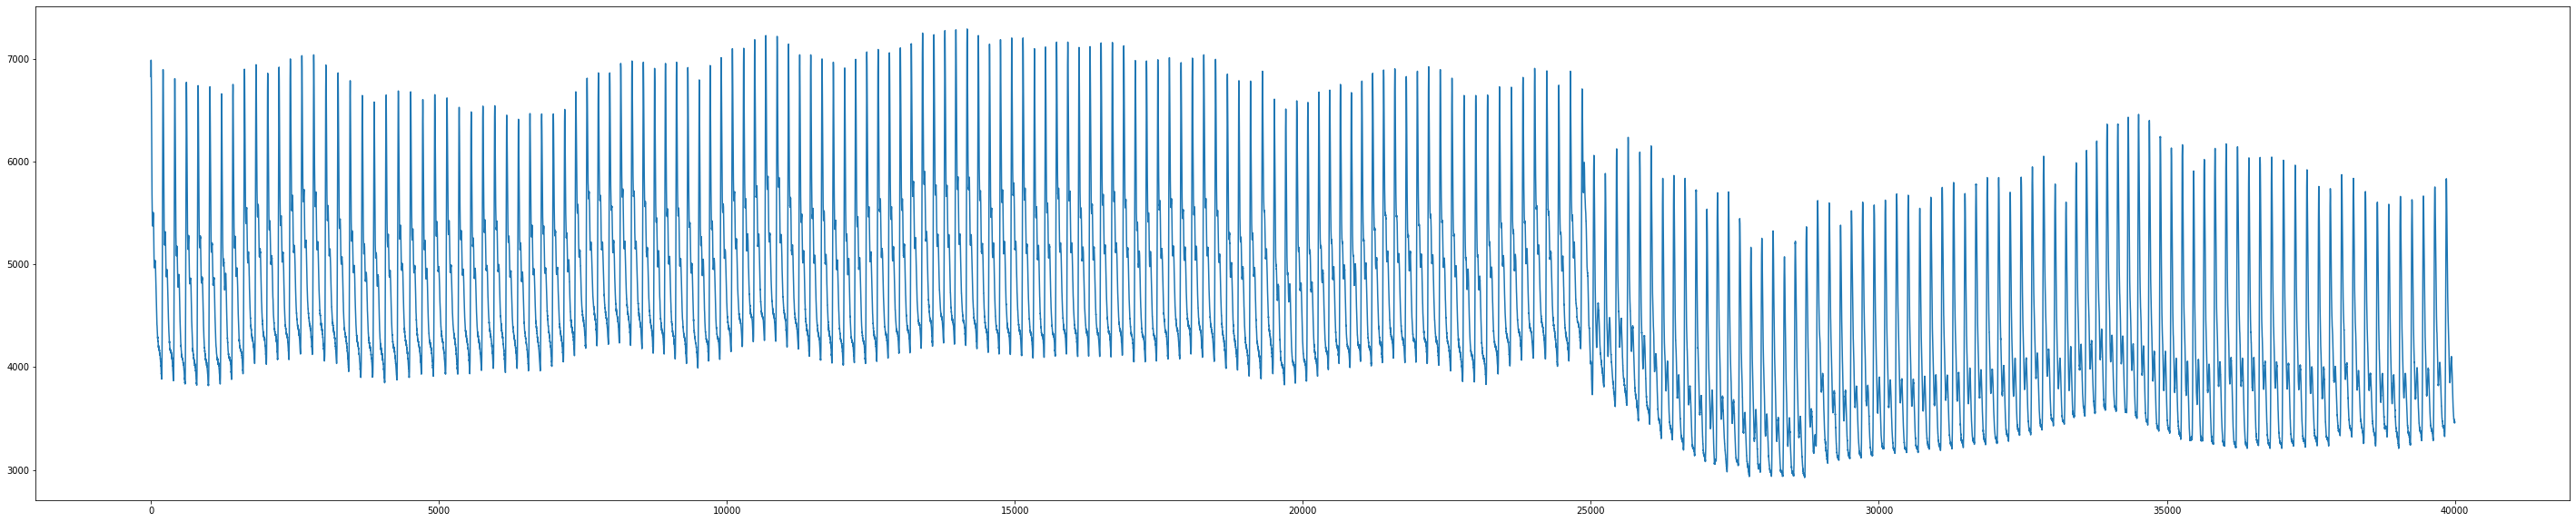

In [5]:
data["abp"].plot()

## Make "experts" clusters:
 - E - optimal
 - E2 - with additional cluster split to see merge recommendation
### 2000, 3000, etc are just clusters labels

<AxesSubplot:>

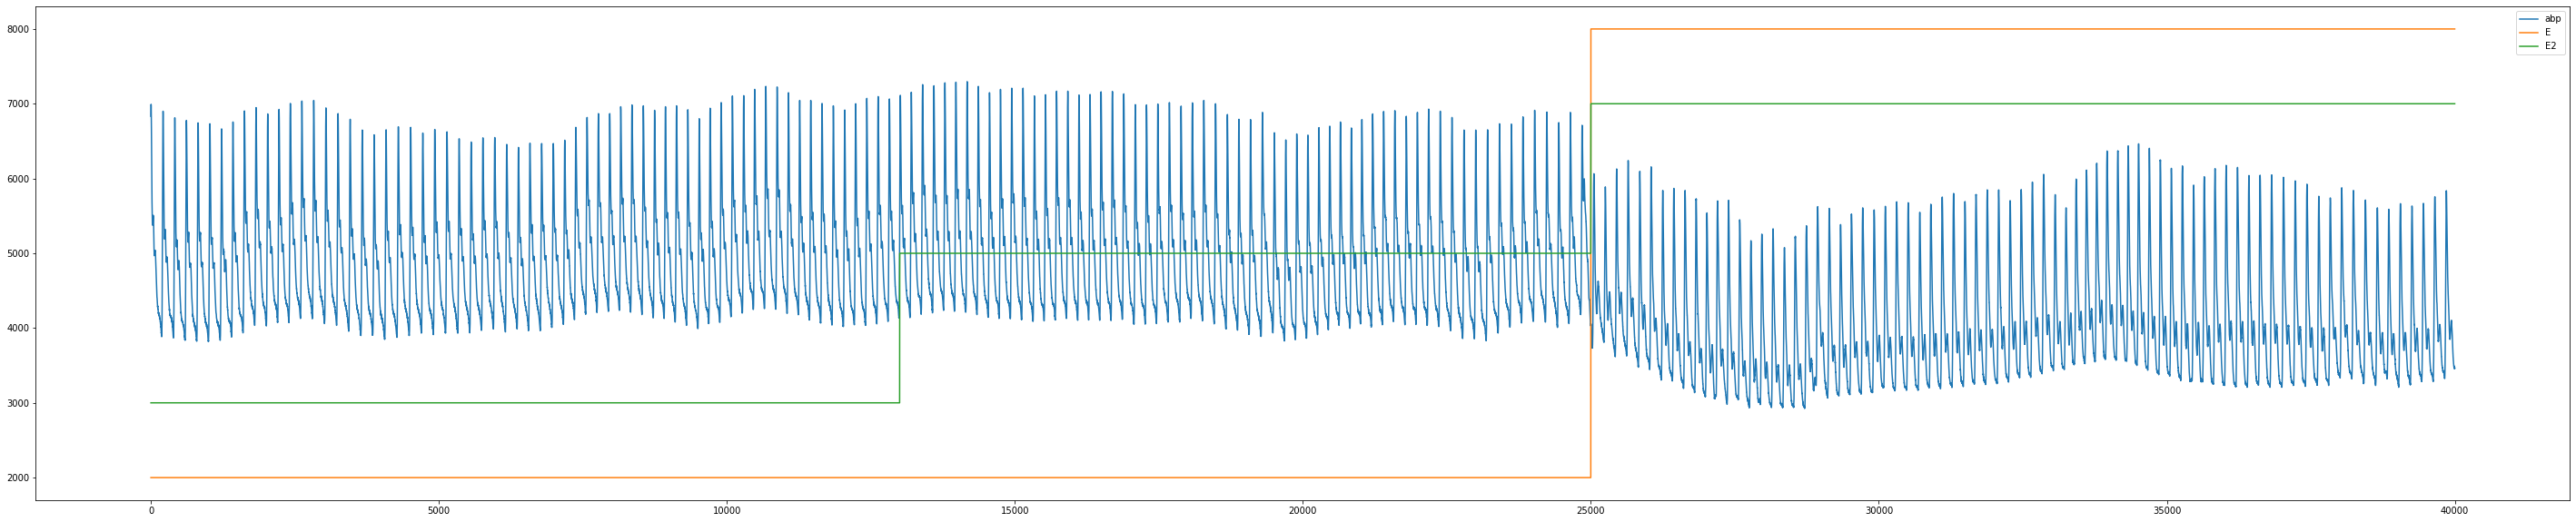

In [6]:
data.loc[0:25000, "E"] = 2000
data.loc[25000:40000, "E"] = 8000

data.loc[0:13000, "E2"] = 3000
data.loc[13000:25000, "E2"] = 5000
data.loc[25000:40000, "E2"] = 7000


data[["abp", "E", "E2"]].plot()

In [10]:
print(data.iloc[24998:25002])

        time     abp       E      E2
24998  24998  4044.0  2000.0  5000.0
24999  24999  4032.0  2000.0  5000.0
25000  25000  4044.0  8000.0  7000.0
25001  25001  4060.0  8000.0  7000.0


## DeepVATS clustering
- clusters_windows_....csv - clusters for windows - it is a daa frame on which embeddings are calculated
- clusters_obs_....csv - most frequent cluster is calculated from overlapping windows; not all observations must have a cluster

In [11]:
deep_vats_clusters_windows = pd.read_csv('~/notebooks/knack/clusters_windows_mozo_DeepVATS_ArterialBloodPressureDuringReclining_v3.csv')
print(deep_vats_clusters_windows.info())
deep_vats_clusters_windows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3980 entries, 0 to 3979
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   window_idx  3980 non-null   int64
 1   cluster     3980 non-null   int64
 2   obs_start   3980 non-null   int64
 3   obs_end     3980 non-null   int64
dtypes: int64(4)
memory usage: 124.5 KB
None


,window_idx,cluster,obs_start,obs_end
0,1,1,0,210
1,2,1,10,220
2,3,0,20,230
3,4,0,30,240
4,5,0,40,250
...,...,...,...,...
3975,3976,2,39750,39960
3976,3977,2,39760,39970
3977,3978,2,39770,39980
3978,3979,2,39780,39990


In [12]:
# There are 3 clusters:
print(deep_vats_clusters_windows["cluster"].value_counts())

0    2188
2    1495
1     297
Name: cluster, dtype: int64


In [13]:
deep_vats_clusters = pd.read_csv('~/notebooks/knack/clusters_obs_mozo_DeepVATS_ArterialBloodPressureDuringReclining_v3.csv')
print(deep_vats_clusters.info())
deep_vats_clusters

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   idx                40000 non-null  int64 
 1   clusters           40000 non-null  object
 2   most_freq_cluster  40000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 937.6+ KB
None


,idx,clusters,most_freq_cluster
0,0,1,1
1,1,1,1
2,2,1,1
3,3,1,1
4,4,1,1
...,...,...,...
39995,39995,2,2
39996,39996,2,2
39997,39997,2,2
39998,39998,2,2


In [14]:
# The same 3 clusters:
print(deep_vats_clusters["most_freq_cluster"].value_counts())

0    24751
2    14980
1      269
Name: most_freq_cluster, dtype: int64


In [18]:
# print(deep_vats_clusters.iloc[24998:25002])
print(deep_vats_clusters.iloc[39998:])

         idx clusters  most_freq_cluster
39998  39998        2                  2
39999  39999        2                  2


<AxesSubplot:>

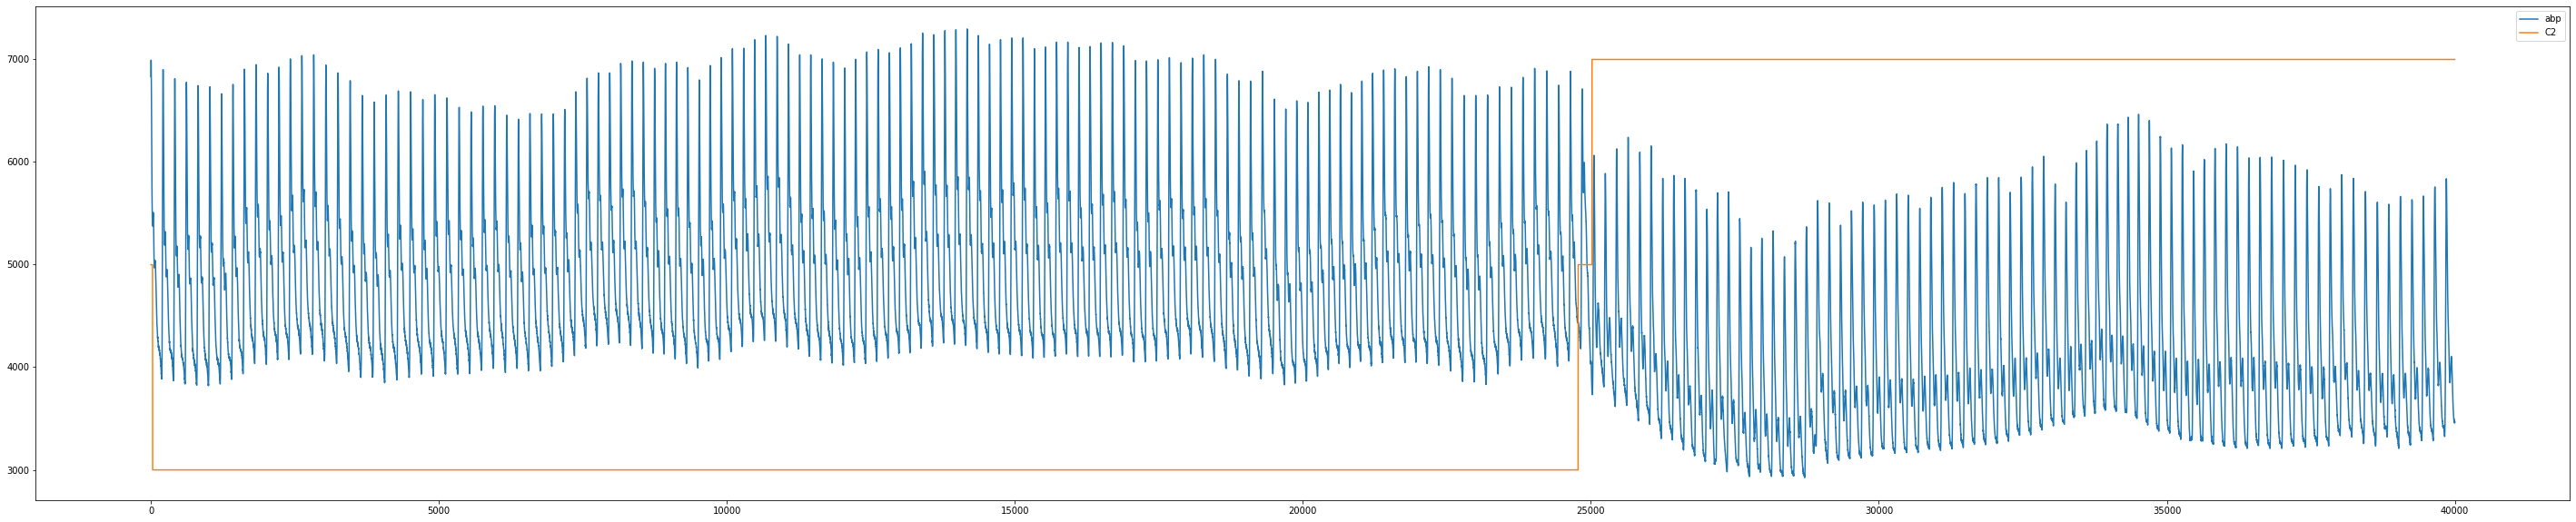

In [20]:
data["C"] = deep_vats_clusters['most_freq_cluster']
# C2 for visualisation:
data["C2"] = data["C"].apply(lambda x: 2999 if x == 0 else 4999 if x == 1 else 6999)
data[["abp", "C2"]].plot()

In [24]:
data.loc[25015:25025, ["time", "C", "C2"]]

,time,C,C2
25015,25015,1,4999
25016,25016,1,4999
25017,25017,1,4999
25018,25018,1,4999
25019,25019,1,4999
25020,25020,2,6999
25021,25021,2,6999
25022,25022,2,6999
25023,25023,2,6999
25024,25024,2,6999


# Do not use observations with DeepVATS clusters (most frequent cluster) calculated from not enough windows
- formula: (windows_size / stride) / (number_of_cluster)

In [27]:
data_trimmed = remove_obs_based_on_windows(deep_vats_clusters_windows, deep_vats_clusters, data, 'cluster', 210, 8)
data_trimmed

got 3 clusters from DeepVATS


,time,abp,E,E2,C,C2
79,79,4996.0,2000.0,3000.0,0,2999
80,80,4972.0,2000.0,3000.0,0,2999
81,81,4960.0,2000.0,3000.0,0,2999
82,82,4924.0,2000.0,3000.0,0,2999
83,83,4908.0,2000.0,3000.0,0,2999
...,...,...,...,...,...,...
39915,39915,3852.0,8000.0,7000.0,2,6999
39916,39916,3848.0,8000.0,7000.0,2,6999
39917,39917,3860.0,8000.0,7000.0,2,6999
39918,39918,3856.0,8000.0,7000.0,2,6999


In [22]:
knack_df_split = data.pivot_table(index='E',columns='C',values='abp',aggfunc='count').fillna(0) 
knack_df_split

C,0,1,2
E,,,
2000.0,24751.0,249.0,0.0
8000.0,0.0,20.0,14980.0


In [23]:
knac2_splits = KnacSplits(confidence_threshold=0.9, # Assign value from  range: (0.0 ; 1.0)
    silhouette_weight=0.2)    # Assign value from  range: (0.0 ; 1.0)
knac_splits_recoms = knac2_splits.fit_transform(knack_df_split, y=None, data=data[["abp", "E", "C"]], labels_automatic=data['C'].astype(str), labels_expert=data['E'])


In [24]:
print(knac_splits_recoms)

E
2000.0    [(0, 1), 0.8152534906047071]
Name: split, dtype: object


In [25]:
knack_df_merges = data.pivot_table(index='E2',columns='C',values='abp',aggfunc='count').fillna(0)
knack_df_merges

C,0,1,2
E2,,,
3000.0,12971.0,29.0,0.0
5000.0,11780.0,220.0,0.0
7000.0,0.0,20.0,14980.0


In [26]:
knac1_merges = KnacMerges(confidence_threshold=0.9, # Assign value from  range: (0.0 ; 1.0)
                    metric='centroids_link',    # Select one of the following options ['single_link', 'average_link',
                                              #                                       'complete_link', 'centroids_link', 'wards_link']
                    metric_weight=0.2)        # Assign value from  range: (0.0 ; 1.0)
knac_merges_recoms=knac1_merges.fit_transform(knack_df_merges, data=data[["abp", "E2", "C"]].values,labels_expert=data['E2'])

In [27]:
knac_merges_recoms

,C1,C2,similarity
1,3000.0,5000.0,0.902261


## Explain splits
  * We explain differences between two clusters with complex model, and Anchor
  * We explain splits by building surogate decision tree on the subset containing only these splited data


### Explanation based on complex model and anchor

In [151]:
data

,time,abp,E,E2,C,C2,cluster
0,0,6832.0,2000.0,3000.0,1,4999,-1
1,1,6928.0,2000.0,3000.0,1,4999,-1
2,2,6968.0,2000.0,3000.0,1,4999,-1
3,3,6992.0,2000.0,3000.0,1,4999,-1
4,4,6980.0,2000.0,3000.0,1,4999,-1
...,...,...,...,...,...,...,...
39995,39995,3468.0,8000.0,7000.0,2,6999,-1
39996,39996,3460.0,8000.0,7000.0,2,6999,-1
39997,39997,3456.0,8000.0,7000.0,2,6999,-1
39998,39998,3472.0,8000.0,7000.0,2,6999,-1


In [192]:
data_agg_by_c = get_agg_stats_by_clusters(data, 'C', "abp", ['E', 'E2', 'C2'])
data_agg_by_c

,C,abp_mean,abp_std,abp_min,abp_max,E,E2,C2
0,0,4917.306775,750.352866,3820.0,7296.0,2000.0,3000.0,2999
1,1,5074.230483,860.811292,3768.0,6992.0,2000.0,5000.0,4999
2,2,4008.701736,739.920984,2924.0,6464.0,8000.0,7000.0,6999


In [169]:
deep_vats_clusters_windows

,window_idx,cluster,obs_start,obs_end
0,1,1,0,210
1,2,1,10,220
2,3,0,20,230
3,4,0,30,240
4,5,0,40,250
...,...,...,...,...
3975,3976,2,39750,39960
3976,3977,2,39760,39970
3977,3978,2,39770,39980
3978,3979,2,39780,39990


In [170]:
df_dvats_clusters_to_data = clusters_to_observations(deep_vats_clusters_windows, data, 'cluster')
df_dvats_clusters_to_data

,time,abp,E,E2,C,C2,cluster,window_idx
0,0,6832.0,2000.0,3000.0,1,4999,1,1
1,1,6928.0,2000.0,3000.0,1,4999,1,1
2,2,6968.0,2000.0,3000.0,1,4999,1,1
3,3,6992.0,2000.0,3000.0,1,4999,1,1
4,4,6980.0,2000.0,3000.0,1,4999,1,1
...,...,...,...,...,...,...,...,...
39995,39995,3468.0,8000.0,7000.0,2,6999,2,3980
39996,39996,3460.0,8000.0,7000.0,2,6999,2,3980
39997,39997,3456.0,8000.0,7000.0,2,6999,2,3980
39998,39998,3472.0,8000.0,7000.0,2,6999,2,3980


In [184]:
print(df_dvats_clusters_to_data.loc[df_dvats_clusters_to_data['window_idx']==1]['E'].unique())
print(df_dvats_clusters_to_data.loc[df_dvats_clusters_to_data['window_idx']==1]['E2'].unique())
print(df_dvats_clusters_to_data.loc[df_dvats_clusters_to_data['window_idx']==1]['C2'].unique())

[2000.]
[3000.]
[4999 2999]


In [204]:
data_agg_by_window = get_agg_stats_by_clusters(df_dvats_clusters_to_data, 'window_idx', "abp", ['C', 'E', 'E2', 'C2'])
data_agg_by_window

for 'window_idx'=1 got 'C'=[1 0]
for 'window_idx'=1 got 'E'=[2000.]
for 'window_idx'=1 got 'E2'=[3000.]
for 'window_idx'=1 got 'C2'=[4999 2999]


,window_idx,abp_mean,abp_std,abp_min,abp_max,C,E,E2,C2
0,1,4860.834123,823.647767,3884.0,6992.0,1.0,2000.0,3000.0,4999.0
1,2,4848.985782,797.073083,3884.0,6900.0,0.0,2000.0,3000.0,2999.0
2,3,4829.876777,770.882416,3884.0,6900.0,0.0,2000.0,3000.0,2999.0
3,4,4819.109005,763.382474,3884.0,6900.0,0.0,2000.0,3000.0,2999.0
4,5,4812.151659,758.426627,3884.0,6900.0,0.0,2000.0,3000.0,2999.0
...,...,...,...,...,...,...,...,...,...
3975,3976,4077.914692,680.234842,3324.0,5836.0,2.0,8000.0,7000.0,6999.0
3976,3977,4070.236967,683.533453,3324.0,5836.0,2.0,8000.0,7000.0,6999.0
3977,3978,4064.208531,687.420488,3324.0,5836.0,2.0,8000.0,7000.0,6999.0
3978,3979,4061.516588,689.533268,3324.0,5836.0,2.0,8000.0,7000.0,6999.0


In [194]:
df_dvats_clusters_to_data_agg_by_cluster = get_agg_stats_by_clusters(df_dvats_clusters_to_data, 'cluster', "abp", ['E', 'E2', 'C2'])
df_dvats_clusters_to_data_agg_by_cluster.rename(columns={"cluster": "C"}, inplace=True)
df_dvats_clusters_to_data_agg_by_cluster

,C,abp_mean,abp_std,abp_min,abp_max,E,E2,C2
0,0,4906.300623,741.695950,3820.0,7296.0,2000.0,3000.0,2999
1,1,5007.263025,819.356937,3064.0,7296.0,2000.0,5000.0,2999
2,2,4012.421019,741.668822,2924.0,6788.0,8000.0,7000.0,6999


In [195]:
data_agg_by_c

,C,abp_mean,abp_std,abp_min,abp_max,E,E2,C2
0,0,4917.306775,750.352866,3820.0,7296.0,2000.0,3000.0,2999
1,1,5074.230483,860.811292,3768.0,6992.0,2000.0,5000.0,4999
2,2,4008.701736,739.920984,2924.0,6464.0,8000.0,7000.0,6999


In [196]:
df_data = data[['time', 'abp', 'E', 'E2', 'C', 'C2']].reset_index()
del df_data['index']
df_data

,time,abp,E,E2,C,C2
0,0,6832.0,2000.0,3000.0,1,4999
1,1,6928.0,2000.0,3000.0,1,4999
2,2,6968.0,2000.0,3000.0,1,4999
3,3,6992.0,2000.0,3000.0,1,4999
4,4,6980.0,2000.0,3000.0,1,4999
...,...,...,...,...,...,...
39995,39995,3468.0,8000.0,7000.0,2,6999
39996,39996,3460.0,8000.0,7000.0,2,6999
39997,39997,3456.0,8000.0,7000.0,2,6999
39998,39998,3472.0,8000.0,7000.0,2,6999


## explanations based on windows

In [205]:
data_expl = data_agg_by_window

In [206]:
features= list(set(data_expl.columns) - set(['C', 'C2', 'time', 'abp', 'E', 'E2', 'window_idx']))
print(features)
all_cols = features + ['C', 'E', 'E2']
print(all_cols)
target='C'

['abp_max', 'abp_min', 'abp_std', 'abp_mean']
['abp_max', 'abp_min', 'abp_std', 'abp_mean', 'C', 'E', 'E2']


# Explain splits

In [200]:
print(knac_splits_recoms)

E
2000.0    [(0, 1), 0.8152534906047071]
Name: split, dtype: object


In [201]:
which_recom = 0

split_recoms=list(knac_splits_recoms.iloc[which_recom][0])
expert_to_split=knac_splits_recoms.index[which_recom]

print(expert_to_split)

2000.0


<AxesSubplot:>

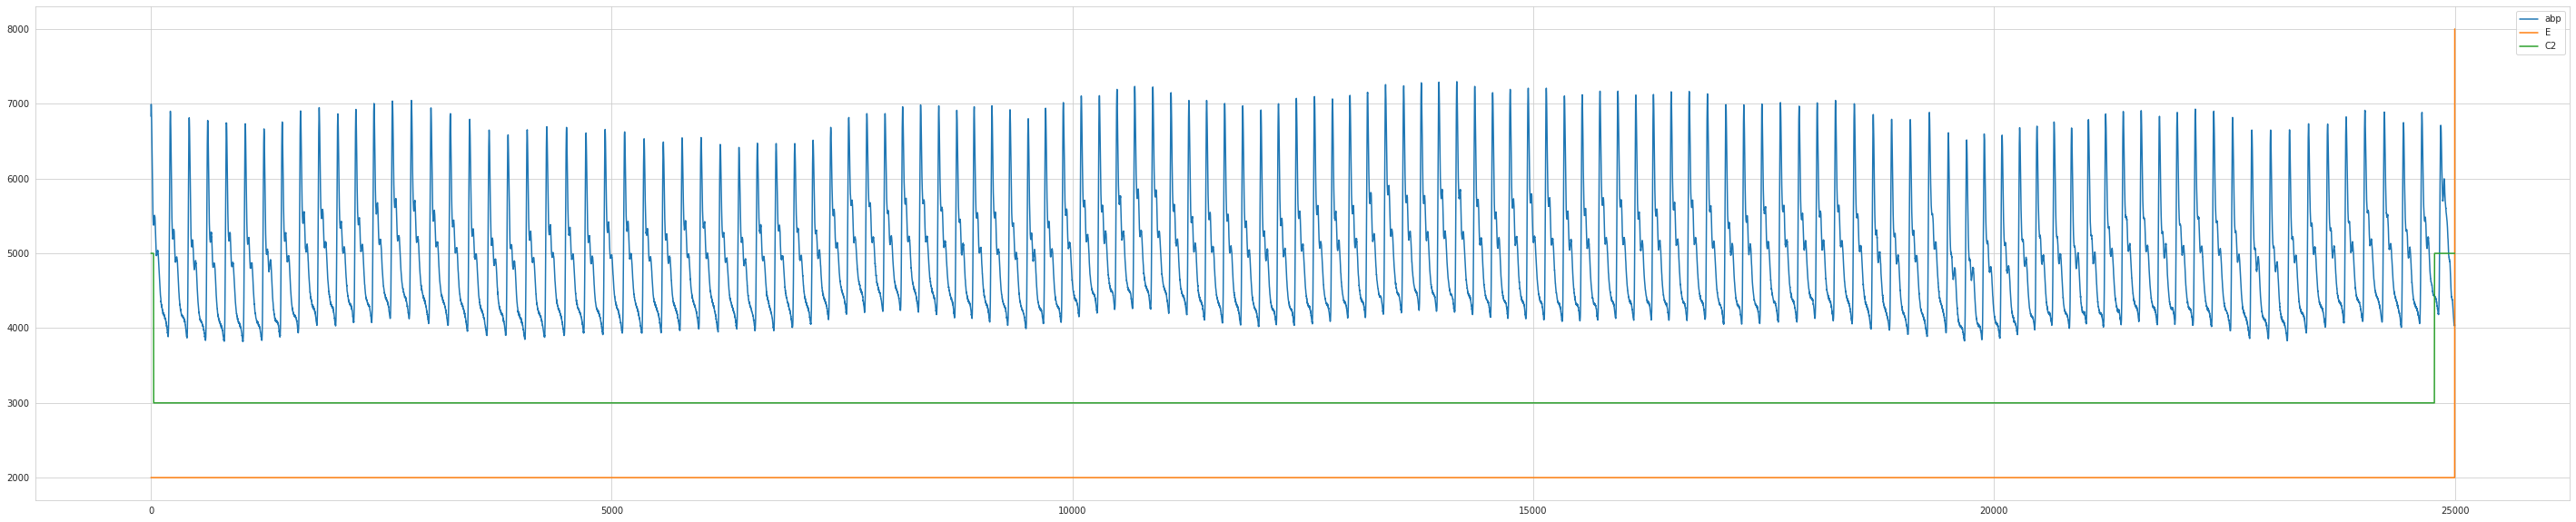

In [94]:
data.loc[0:25000, ["abp", "E", "C2"]].plot()

In [207]:
justify_splits_anchor(expert_to_split=expert_to_split,
                      split_recoms=split_recoms,
                      data=data_expl[all_cols],
                      features=features,
                      target_automatic=target)

The rule for automatic cluster 0: 
Precision: 0.99
Coverage: 1.00
The rule for automatic cluster 1: 
Precision: 1.00
Coverage: 1.00


In [208]:
justify_splits_tree(expert_to_split=expert_to_split,
                    split_recoms=split_recoms,
                    data=data_expl[all_cols],
                    features=features,
                    target_automatic=target)

['if (abp_min > 3792.0) then class: 0.0 (proba: 99.48%) | based on 2,481 samples',
 'if (abp_min <= 3792.0) then class: 1.0 (proba: 100.0%) | based on 12 samples']

## Explain merges
We explain merges in the sam eway as above, but now, decision are expert labels.
We leave the decision if the condition for splitting is sufficient, or is it redundant, or artificial to an expert

In [209]:
target_sur='E2'

In [110]:
knac_merges_recoms

,C1,C2,similarity
1,3000.0,5000.0,0.902261


In [210]:
which_recom = 0

merge_recoms=list(knac_merges_recoms.iloc[which_recom, 0:2])

print(merge_recoms)

[3000.0, 5000.0]


<AxesSubplot:>

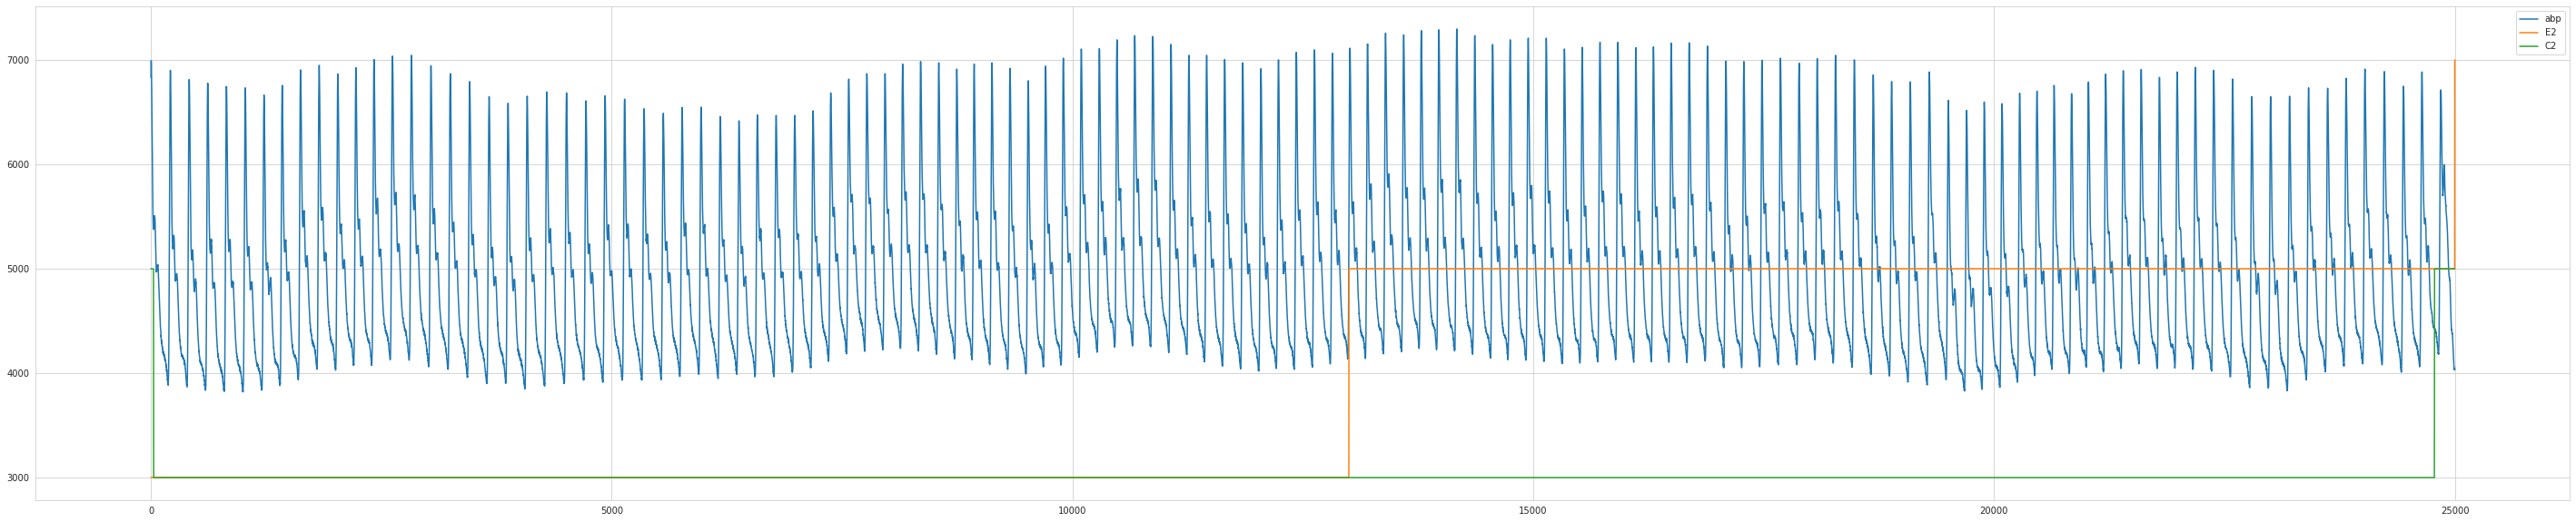

In [112]:
data.loc[0:25000, ["abp", "E2", "C2"]].plot()

In [211]:
justify_merges_anchor(merge_recoms=merge_recoms, data=data_expl[all_cols], features=features, target_expert=target_sur)

/home/mmozolewski/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The rule for automatic cluster 3000.0: abp_mean > 4775.53 AND abp_std > 687.94 AND abp_max <= 6960.00 AND abp_min <= 4076.00
Precision: 0.74
Coverage: 0.16
The rule for automatic cluster 5000.0: abp_max <= 6960.00 AND abp_min > 3932.00 AND abp_mean > 4775.53 AND 725.76 < abp_std <= 762.45
Precision: 0.72
Coverage: 0.06


In [212]:
justify_merges_tree(merge_recoms=merge_recoms, data=data_expl[all_cols], features=features, target_expert=target_sur) ###  TODO Czemu tłumaczy to na deepvatsowych (C), a nie Eksperckich

['if (abp_max <= 7114.0) then class: 0 (proba: 59.39%) | based on 2,039 samples',
 'if (abp_max > 7114.0) then class: 1 (proba: 82.3%) | based on 452 samples']

# Observations with enough clusters on window level to take most frequent cluster

In [117]:
deep_vats_clusters

,idx,clusters,most_freq_cluster,cluster_count
0,0,1,1,1
1,1,1,1,1
2,2,1,1,1
3,3,1,1,1
4,4,1,1,1
...,...,...,...,...
39995,39995,2,2,1
39996,39996,2,2,1
39997,39997,2,2,1
39998,39998,2,2,1


got 3 clusters from DeepVATS


,time,abp,E,E2,C,C2,cluster
79,79,4996.0,2000.0,3000.0,0,2999,0
80,80,4972.0,2000.0,3000.0,0,2999,0
81,81,4960.0,2000.0,3000.0,0,2999,0
82,82,4924.0,2000.0,3000.0,0,2999,0
83,83,4908.0,2000.0,3000.0,0,2999,0
...,...,...,...,...,...,...,...
39915,39915,3852.0,8000.0,7000.0,2,6999,2
39916,39916,3848.0,8000.0,7000.0,2,6999,2
39917,39917,3860.0,8000.0,7000.0,2,6999,2
39918,39918,3856.0,8000.0,7000.0,2,6999,2
